In [8]:
from juliacall import Main as jl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import multiprocessing as mp


###################################################
# plt.rcParams['text.usetex'] = True
# plt.rcParams.update({'font.size': 25})
# plt.rcParams.update({'figure.facecolor': 'white'})
# plt.rcParams.update({'savefig.facecolor': 'white'})
###########################################

"""For high dimensions, it is much easier to sample from distribution then compute marginals, 
instead of computing marginals from the pdf """

# colors
blue, orange, magenta, grey, green = '#0db4c3', '#eea021', '#ff0364', '#606172', '#3fb532'

# ===========================================================================

#long to run???
jl.seval("""using SequentialMeasureTransport""")
jl.seval("""import SequentialMeasureTransport as SMT""")
jl.seval("""using Distributions""")
jl.seval("""using PythonCall""")

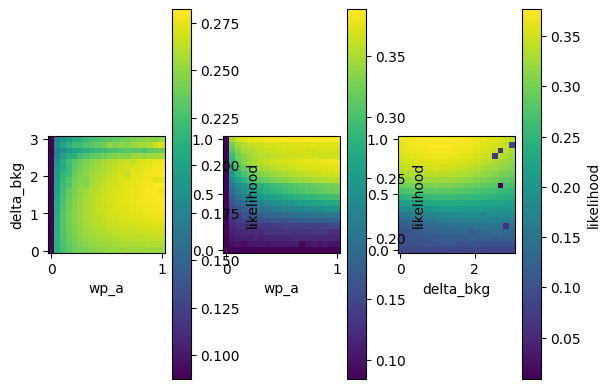

In [14]:

loaded_reference_likelihood3 = np.load('reference_likelihood3_n20.npz', allow_pickle=True)
ds = xr.Dataset( {'likelihood': (['Cent','delta_bkg','wp_a'],loaded_reference_likelihood3['likelihood_output'])}, coords={'Cent': loaded_reference_likelihood3['Cent'],'delta_bkg': loaded_reference_likelihood3['delta_bkg'], 'wp_a': loaded_reference_likelihood3['wp_a']  })
fig, axs = plt.subplots(nrows=1, ncols=3)
ds['likelihood'].mean('Cent').plot(ax=axs.flat[0])
ds['likelihood'].mean('delta_bkg').plot(ax=axs.flat[1])
im = ds['likelihood'].mean('wp_a').plot(ax=axs.flat[2])

for ax in axs.flat:
    ax.set_box_aspect(1)


In [15]:
sampler_name = 'sampler_likelihood3_N300_L8_phi50_algb1_2_lambda2_1e-4.jld2'
print('Load sampler and sample')
jl.seval(f"""smp = SMT.load_sampler("{sampler_name}")""")
smp_instance = jl.smp


Load sampler and sample


In [26]:
def infered_pdf(x):
    return jl.pdf(smp_instance, x)

infered_pdf = np.vectorize(infered_pdf)


In [17]:
Cent_range      = ds['Cent']
delta_bkg_range = ds['delta_bkg']
wp_a_range      = ds['wp_a']


In [18]:

X,Y,Z = np.meshgrid(Cent_range,delta_bkg_range,wp_a_range,indexing='ij')

# Flatten the grids to create a list of points
points = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T


In [30]:
points[0]

array([0.  , 0.03, 0.  ])

In [29]:
infered_pdf(points[0])

TypeError: Julia: MethodError: no method matching pdf(::SequentialMeasureTransport.CondSampler{3, 0, Float64, SequentialMeasureTransport.ReferenceMaps.ScalingReference{3, 0, Float64}, SequentialMeasureTransport.ReferenceMaps.ScalingReference{3, 0, Float64}}, ::Float64)

Closest candidates are:
  pdf(!Matched::Chernoff, ::Real)
   @ Distributions ~/.julia/packages/Distributions/UaWBm/src/univariate/continuous/chernoff.jl:154
  pdf(!Matched::Symbolics.Num, ::Real)
   @ Symbolics ~/.julia/packages/Symbolics/PAFGz/src/wrapper-types.jl:140
  pdf(!Matched::Hypergeometric, ::Real)
   @ Distributions ~/.julia/packages/Distributions/UaWBm/src/univariates.jl:644
  ...


In [19]:

# Use multiprocessing to compute f(x, y, z) in parallel
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(infered_pdf, points)

# Reshape the results back to the original 3D shape
infered_pdf_output = np.array(results).reshape(X.shape)


KeyboardInterrupt: 

In [ ]:
infered_pdf_output

array([[[7.44224364e+06, 3.52749663e+03, 8.84867816e+02, ...,
         7.74443522e+01, 2.08057603e+02, 5.18831412e+06],
        [4.36365385e+04, 3.03831731e+00, 1.45792926e+00, ...,
         5.65078540e+00, 5.07945915e+00, 2.58263737e+04],
        [1.12761198e+04, 1.56170850e+00, 5.59250594e-01, ...,
         9.44549265e-01, 8.04798079e-01, 5.37348607e+03],
        ...,
        [5.04016741e+03, 6.30722062e-01, 1.28560870e+00, ...,
         5.59561198e-01, 2.04106154e+00, 6.74827526e+03],
        [1.32056310e+04, 4.37033432e+00, 2.26026246e+00, ...,
         3.67239670e+00, 1.25267064e+01, 1.59885001e+04],
        [2.31405693e+09, 4.71925525e+05, 6.02504061e+04, ...,
         3.86684471e+03, 1.13992850e+04, 2.14071753e+09]],

       [[2.85617759e+05, 8.72192906e+00, 1.23175370e+00, ...,
         1.46948460e+00, 1.70732134e+00, 2.21261277e+05],
        [3.27879527e+00, 2.44245875e-03, 6.91341923e-04, ...,
         4.21280182e-01, 1.68737933e-01, 4.54258801e+00],
        [1.61356314e+00, 

In [ ]:
ds = xr.Dataset( {'likelihood': (['Cent','delta_bkg','wp_a'],loaded_reference_likelihood3['likelihood_output'])}, coords={'Cent': loaded_reference_likelihood3['Cent'],'delta_bkg': loaded_reference_likelihood3['delta_bkg'], 'wp_a': loaded_reference_likelihood3['wp_a']  })
fig, axs = plt.subplots(nrows=1, ncols=3)
ds['likelihood'].mean('Cent').plot(ax=axs.flat[0])
ds['likelihood'].mean('delta_bkg').plot(ax=axs.flat[1])
im = ds['likelihood'].mean('wp_a').plot(ax=axs.flat[2])

In [ ]:
ds = ds.assign({'estimated_pdf': (['Cent','delta_bkg','wp_a'],infered_pdf_output)})

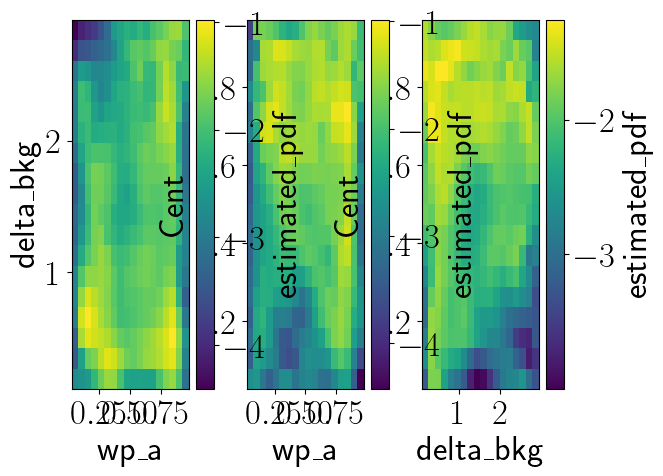

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3)
np.log(ds['estimated_pdf'][1:-1,1:-1,1:-1]).mean('Cent').plot(ax=axs.flat[0])
np.log(ds['estimated_pdf'][1:-1,1:-1,1:-1]).mean('delta_bkg').plot(ax=axs.flat[1])
im = np.log(ds['estimated_pdf'][1:-1,1:-1,1:-1]).mean('wp_a').plot(ax=axs.flat[2])
